In [61]:
from matplotlib import pyplot as plt
import scipy as sc
import pandas
import math
import numpy as np
import lmfit
import os
from uncertainties import ufloat
import array_to_latex as atl
from uncertainties import unumpy as up

In [62]:
plt.rc ('font', size = 15) # steuert die Standardtextgröße
plt.rc ('axes', titlesize = 15) # Schriftgröße des Titels
plt.rc ('axes', labelsize = 15) # Schriftgröße der x- und y-Beschriftungen
plt.rc ('xtick', labelsize = 15) #Schriftgröße der x-Tick-Labels
plt.rc ('ytick', labelsize = 15) #Schriftgröße der y-Tick-Labels
plt.rc ('legend', fontsize = 15) #Schriftgröße der Legende

In [63]:
def pos(x):
    for i in range(len(data[0])):
        if data[0,i]>=x:
            return i
            break


FitFunktionen

In [83]:
def gaus1fit(von,bis,path,yscale,m=1,mmin=0,mmax=2,s=0.2,smax=1000,scale=1e-9,override=False): 
    vonarr = pos(von)
    bisarr = pos(bis)

    model_gaus = lmfit.models.GaussianModel()  
    pars_gaus=model_gaus.guess(data=data[1,vonarr:bisarr],x=data[0,vonarr:bisarr])
    if override:
        #pars_gaus = model_gaus.make_params()
        pars_gaus["center"].set(value=m,min=mmin,max=mmax)
        pars_gaus["sigma"].set(value=1,min=0)
        pars_gaus["amplitude"].set(value=1,min=0)


    #Fitten
    out_gaus = model_gaus.fit(data[1,vonarr:bisarr],x=data[0,vonarr:bisarr],weights=1/data[2,vonarr:bisarr],params=pars_gaus,nan_policy='propagate')

    fig = plt.figure(figsize=(8,6),dpi=80,linewidth=50)
    plt.errorbar(data[0,vonarr:bisarr],yscale*data[1,vonarr:bisarr],yerr=yscale*data[2,vonarr:bisarr],fmt='o',ecolor='lightgray',color='r', elinewidth=3, capsize=0,zorder=5,label="Daten")
    plt.plot(np.arange(von,bis,0.01),yscale*out_gaus.eval(x=np.arange(von,bis,0.01)),zorder=10,color='k',linestyle='-',alpha=0.5,label="Gaus-Fit")
    


    plt.ticklabel_format(style='sci')
    plt.xlabel('Masse zu Ladungsverhältniss [amu]')
    plt.ylabel('Partialdruck [Torr '+str(1/yscale).replace('1e','10^')+']')
    plt.grid()
    plt.legend()
    plt.savefig('Results/'+str(path)+'.pdf')

    print(out_gaus.fit_report())


    return np.array([np.arange(von,bis,0.01),out_gaus.eval(x=np.arange(von,bis,0.01))]), out_gaus




def gaus2fit(von,bis,path,yscale,override=False,m1=1,s1=1,scale1=1,m2=1,s2=1,scale2=1,m1min=1,m1max=1,m2min=1,m2max=1): 
    vonarr = pos(von)
    bisarr = pos(bis)

    model_gaus=lmfit.models.GaussianModel(prefix="g1_")+lmfit.models.GaussianModel(prefix="g2_")

    def guess(data,x):
        params_g1=lmfit.models.GaussianModel(prefix="g1_").guess(data,x)
        params=model_gaus.make_params()
        for i in params_g1:
            params[i]=params_g1[i]
                    
        params["g2_center"].value=params.get("g1_center").value-1
        params["g2_sigma"].value=params.get("g1_sigma").value*0.5
        params["g2_amplitude"].value=params.get("g1_amplitude").value*0.3
        return params

    model_gaus.guess=guess
    pars_gaus = model_gaus.guess(data=data[1,vonarr:bisarr],x=data[0,vonarr:bisarr])
    if override:
        #pars_gaus = model_gaus.make_params()
        pars_gaus["g1_center"].set(value=m1,min=m1min,max=m1max)
        pars_gaus["g1_sigma"].set(value=s1)
        pars_gaus["g1_amplitude"].set(value=scale1,min=0)
        pars_gaus["g2_center"].set(value=m2,min=m2min,max=m2max)
        pars_gaus["g2_sigma"].set(value=s2)
        pars_gaus["g2_amplitude"].set(value=scale2,min=0)


    #Fitten
    out_gaus = model_gaus.fit(data[1,vonarr:bisarr],x=data[0,vonarr:bisarr],weights=1/data[2,vonarr:bisarr],params=pars_gaus,nan_policy='propagate')

    fig = plt.figure(figsize=(8,6),dpi=80,linewidth=50)
    plt.errorbar(data[0,vonarr:bisarr],yscale*data[1,vonarr:bisarr],yerr=yscale*data[2,vonarr:bisarr],fmt='o',ecolor='lightgray',color='r', elinewidth=3, capsize=0,zorder=5,label="Daten")
    plt.plot(np.arange(von,bis,0.01),yscale*out_gaus.eval(x=np.arange(von,bis,0.01)),zorder=10,color='k',linestyle='-',alpha=0.5,label="Gaus-Fit")
    
    plt.xlabel('Masse zu Ladungsverhältniss [amu]')
    plt.ylabel('Partialdruck [Torr '+str(1/yscale).replace('1e','10^')+']')
    plt.grid()
    plt.legend()
    plt.savefig('Results/'+str(path)+'.pdf')

    print(out_gaus.fit_report())

    return np.array([np.arange(von,bis,0.01), out_gaus.eval(x=np.arange(von,bis,0.01))]),out_gaus

Daten einlesen und Standartfehler as Fehler der Counts festlegen

<ErrorbarContainer object of 3 artists>

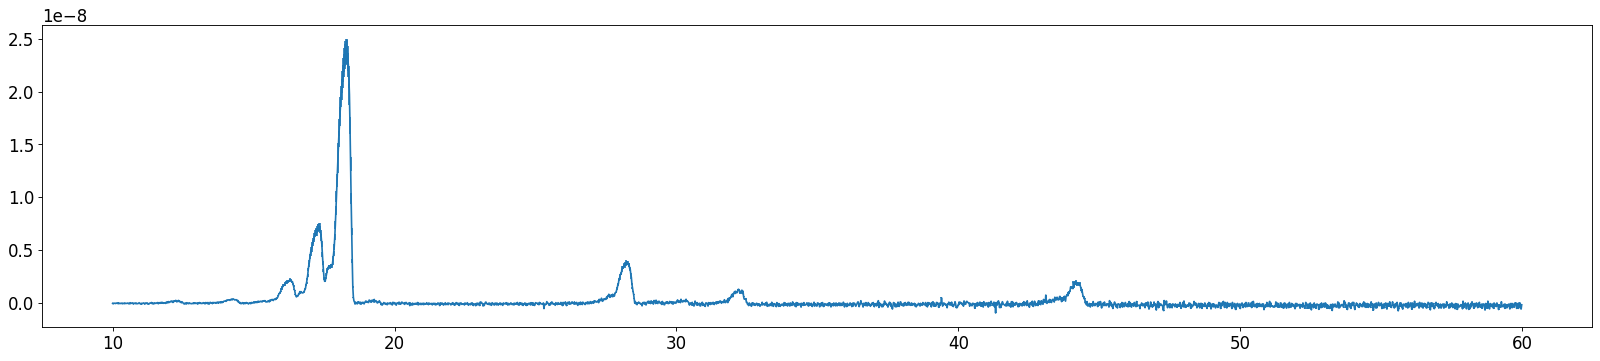

In [84]:

with open('Data/Restgas_3.csv', mode='r') as tf:
        dataex = np.genfromtxt((line.replace(',', '.') for line in tf),delimiter=";",skip_header=21).T
        data = np.zeros((3,len(dataex[3])))
        data[0],data[1] = dataex[3],dataex[4]



err = list(np.zeros(len(data[1])))
for i in range(len(err)):
    err[i] = ufloat(data[1,i],float(abs(data[1,i])*0.05))


for i in range(len(err)):
    err[i] = err[i]*data[0,i]/28

for i in range(len(err)):
    data[1,i]=err[i].n
    data[2,i]=err[i].s

v = pos(10)
b = pos(60)

fig = plt.figure(figsize=(25,5),dpi=80,linewidth=50)
plt.errorbar(data[0,v:b],data[1,v:b],yerr=data[2,v:b],label = 'Data')
#plt.vlines(18.6,0,10e-9)


[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 30
    # variables        = 3
    chi-square         = 4504.71873
    reduced chi-square = 166.841435
    Akaike info crit   = 156.350501
    Bayesian info crit = 160.554093
[[Variables]]
    amplitude:  3.8265e-11 +/- 6.1096e-12 (15.97%) (init = 1.129117e-10)
    center:     12.2061380 +/- 0.01511832 (0.12%) (init = 12.22333)
    sigma:      0.12520058 +/- 0.01187800 (9.49%) (init = 0.16)
    fwhm:       0.29482483 +/- 0.02797056 (9.49%) == '2.3548200*sigma'
    height:     1.2193e-10 +/- 2.5769e-11 (21.13%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma)  = -0.336
    C(amplitude, center) = 0.135


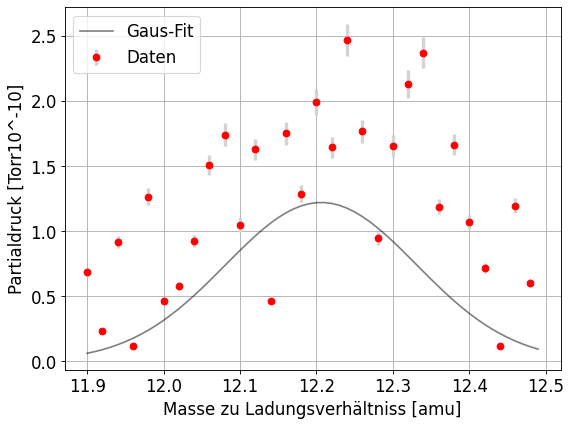

In [85]:
p12 = gaus1fit(11.9,12.5,'Restgas_3_12.2',1e10)


[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 32
    # variables        = 3
    chi-square         = 1002.51339
    reduced chi-square = 34.5694273
    Akaike info crit   = 116.224948
    Bayesian info crit = 120.622155
[[Variables]]
    amplitude:  1.4453e-10 +/- 8.0041e-12 (5.54%) (init = 2.0625e-10)
    center:     14.2074752 +/- 0.00884799 (0.06%) (init = 14.231)
    sigma:      0.16719604 +/- 0.00801760 (4.80%) (init = 0.2)
    fwhm:       0.39371657 +/- 0.01888000 (4.80%) == '2.3548200*sigma'
    height:     3.4485e-10 +/- 2.6457e-11 (7.67%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(center, sigma)     = 0.278
    C(amplitude, center) = 0.153


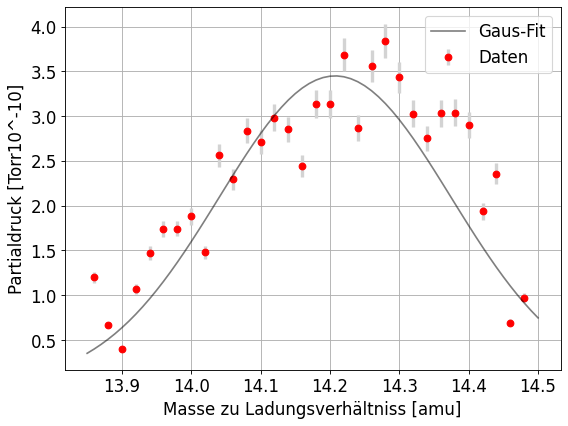

In [87]:
p14 = gaus1fit(13.85,14.5,'Restgas_3_14.2',1e10)

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 37
    # variables        = 3
    chi-square         = 144.586784
    reduced chi-square = 4.25255246
    Akaike info crit   = 56.4295938
    Bayesian info crit = 61.2623475
[[Variables]]
    amplitude:  1.2081e-09 +/- 2.3748e-11 (1.97%) (init = 1.30264e-09)
    center:     16.2170945 +/- 0.00560830 (0.03%) (init = 16.21)
    sigma:      0.22743624 +/- 0.00478589 (2.10%) (init = 0.23)
    fwhm:       0.53557140 +/- 0.01126990 (2.10%) == '2.3548200*sigma'
    height:     2.1191e-09 +/- 5.1055e-11 (2.41%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(center, sigma)     = 0.674
    C(amplitude, center) = 0.497
    C(amplitude, sigma)  = 0.301


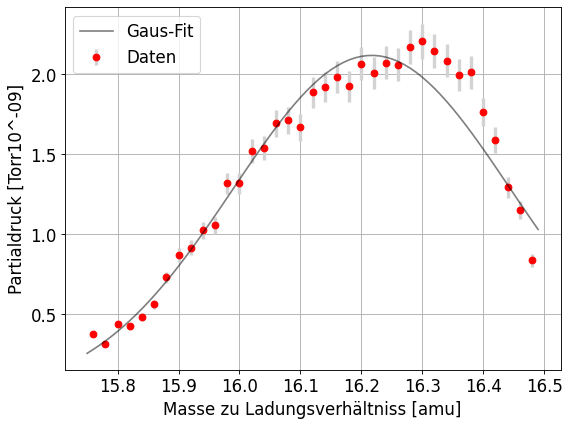

In [88]:
p16 = gaus1fit(15.75,16.5,'Restgas_3_16.2',1e9)

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 35
    # variables        = 3
    chi-square         = 86.6888381
    reduced chi-square = 2.70902619
    Akaike info crit   = 37.7441975
    Bayesian info crit = 42.4102417
[[Variables]]
    amplitude:  3.9264e-09 +/- 6.4206e-11 (1.64%) (init = 4.000013e-09)
    center:     17.2310004 +/- 0.00457651 (0.03%) (init = 17.22)
    sigma:      0.22010920 +/- 0.00391405 (1.78%) (init = 0.22)
    fwhm:       0.51831754 +/- 0.00921689 (1.78%) == '2.3548200*sigma'
    height:     7.1165e-09 +/- 1.3910e-10 (1.95%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(center, sigma)     = 0.681
    C(amplitude, center) = 0.521
    C(amplitude, sigma)  = 0.347


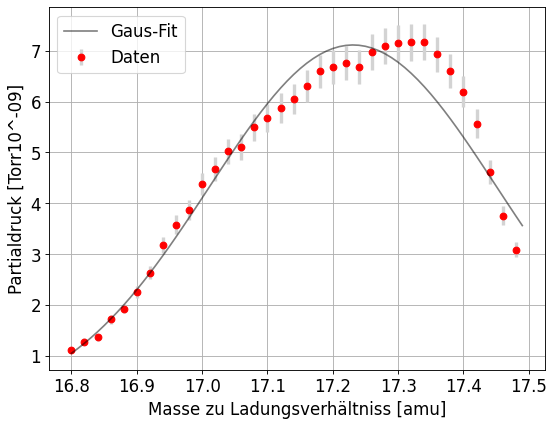

In [89]:
p17 = gaus1fit(16.8,17.5,'Restgas_3_17.2',1e9)

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 38
    # variables        = 3
    chi-square         = 2180.71762
    reduced chi-square = 62.3062178
    Akaike info crit   = 159.893279
    Bayesian info crit = 164.806037
[[Variables]]
    amplitude:  9.6763e-09 +/- 7.2922e-10 (7.54%) (init = 1.605373e-08)
    center:     18.1443946 +/- 0.00930131 (0.05%) (init = 18.21)
    sigma:      0.15618131 +/- 0.00579047 (3.71%) (init = 0.23)
    fwhm:       0.36777886 +/- 0.01363552 (3.71%) == '2.3548200*sigma'
    height:     2.4717e-08 +/- 2.3787e-09 (9.62%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(center, sigma)     = -0.484
    C(amplitude, sigma)  = -0.395
    C(amplitude, center) = 0.221


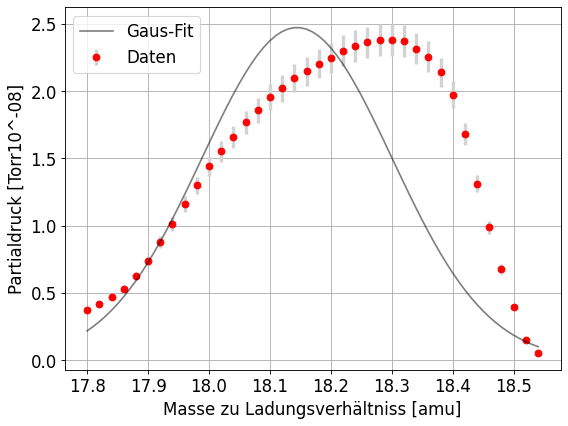

In [90]:
p18 = gaus1fit(17.8,18.55,'Restgas_3_18.2',1e8)#,override=True,m1=18.21,m1min=18.15,m1max=18.5,s1=0.23,scale1=8.940706e-10,m2=17.61,m2min=17.6,m2max=17.8,s2=0.5,scale2=2.682212e-10)

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 40
    # variables        = 3
    chi-square         = 586.139730
    reduced chi-square = 15.8416143
    Akaike info crit   = 113.387150
    Bayesian info crit = 118.453789
[[Variables]]
    amplitude:  1.8894e-09 +/- 6.3956e-11 (3.38%) (init = 2.152186e-09)
    center:     28.1639881 +/- 0.00683758 (0.02%) (init = 28.18)
    sigma:      0.21051957 +/- 0.00652113 (3.10%) (init = 0.22)
    fwhm:       0.49573570 +/- 0.01535610 (3.10%) == '2.3548200*sigma'
    height:     3.5806e-09 +/- 1.7370e-10 (4.85%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(center, sigma)     = 0.396
    C(amplitude, center) = 0.227
    C(amplitude, sigma)  = -0.118


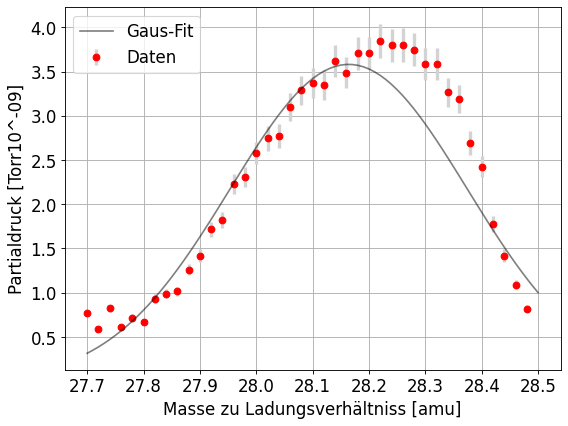

In [91]:
p28 = gaus1fit(27.7,28.5,'Restgas_3_28.2',1e9)

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 35
    # variables        = 3
    chi-square         = 2411.05281
    reduced chi-square = 75.3454003
    Akaike info crit   = 154.136475
    Bayesian info crit = 158.802519
[[Variables]]
    amplitude:  4.5913e-10 +/- 3.9460e-11 (8.59%) (init = 7.605058e-10)
    center:     32.1694846 +/- 0.00824694 (0.03%) (init = 32.168)
    sigma:      0.13632851 +/- 0.00500837 (3.67%) (init = 0.2)
    fwhm:       0.32102909 +/- 0.01179382 (3.67%) == '2.3548200*sigma'
    height:     1.3436e-09 +/- 1.4022e-10 (10.44%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = -0.341
    C(center, sigma)    = 0.136


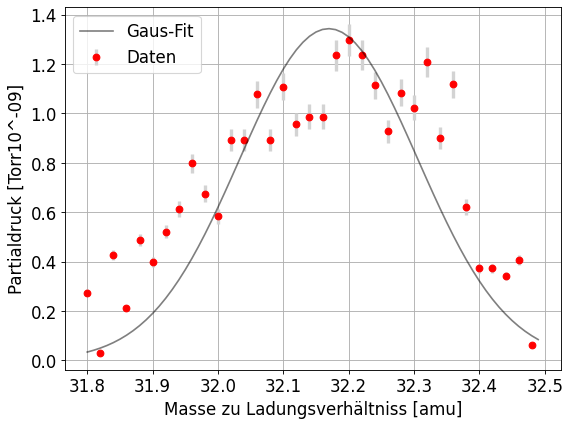

In [92]:
p32 = gaus1fit(31.8,32.5,'Restgas_3_32.2',1e9)

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 45
    # variables        = 3
    chi-square         = 2616.18043
    reduced chi-square = 62.2900101
    Akaike info crit   = 188.826369
    Bayesian info crit = 194.246356
[[Variables]]
    amplitude:  8.9965e-10 +/- 6.1701e-11 (6.86%) (init = 1.202533e-09)
    center:     44.1517932 +/- 0.01192651 (0.03%) (init = 44.17)
    sigma:      0.20104738 +/- 0.01037332 (5.16%) (init = 0.21)
    fwhm:       0.47343038 +/- 0.02442731 (5.16%) == '2.3548200*sigma'
    height:     1.7852e-09 +/- 1.7194e-10 (9.63%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(center, sigma)     = 0.431
    C(amplitude, sigma)  = -0.270
    C(amplitude, center) = 0.116


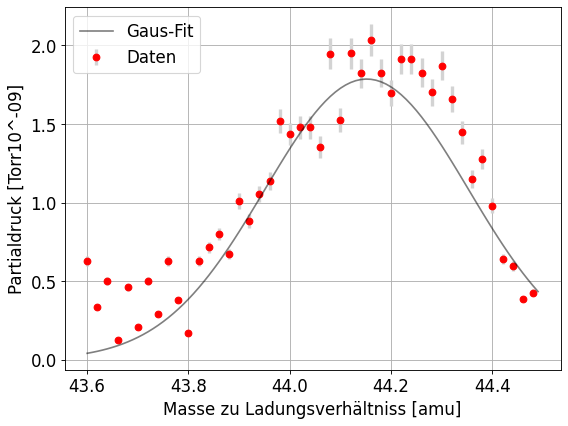

In [93]:
p44 = gaus1fit(43.6,44.5,'Restgas_3_44.2',1e9)

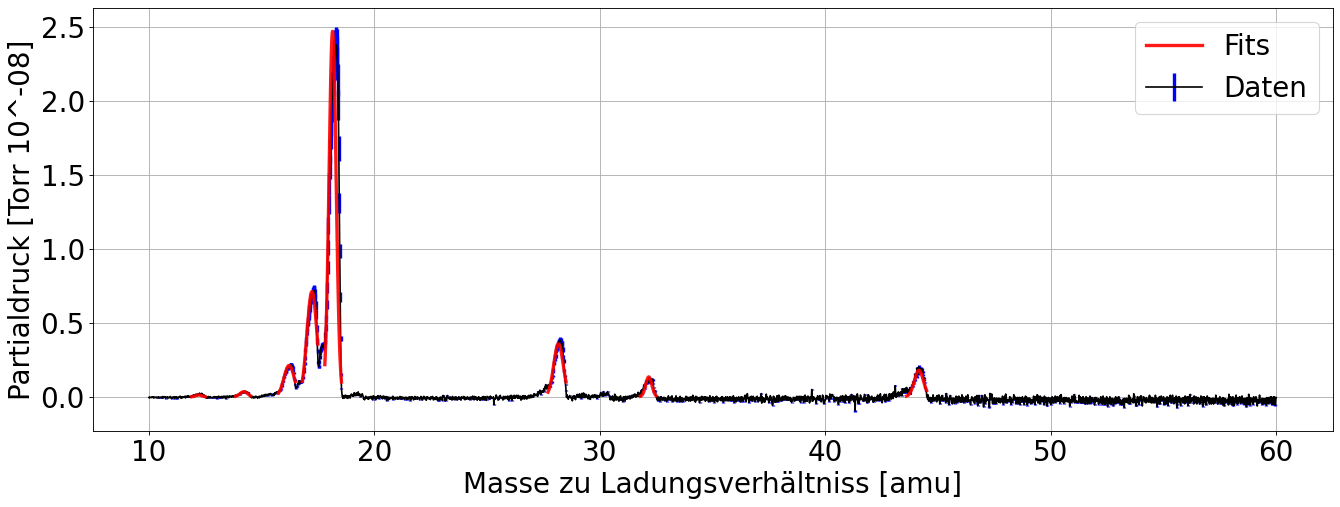

In [101]:
fig = plt.figure(figsize=(20,7),dpi=80,linewidth=50)
yscale = 1e8
plt.rc ('font', size =25) # steuert die Standardtextgröße
plt.rc ('axes', titlesize = 25) # Schriftgröße des Titels
plt.rc ('axes', labelsize = 25) # Schriftgröße der x- und y-Beschriftungen
plt.rc ('xtick', labelsize = 25) #Schriftgröße der x-Tick-Labels
plt.rc ('ytick', labelsize = 25) #Schriftgröße der y-Tick-Labels
plt.rc ('legend', fontsize = 25) #Schriftgröße der Legende


plt.errorbar(data[0],yscale*data[1],yerr=yscale*data[2],zorder=5,mfc='black',color='k',linestyle='-',label='Daten',ecolor='b',elinewidth=3)
plt.plot(p12[0][0],yscale*p12[0][1],zorder=10,label='Fits',color='r',alpha=0.9,linewidth=3)
plt.plot(p14[0][0],yscale*p14[0][1],zorder=10,color='r',alpha=0.9,linewidth=3)
plt.plot(p16[0][0],yscale*p16[0][1],zorder=10,color='r',alpha=0.9,linewidth=3)
plt.plot(p17[0][0],yscale*p17[0][1],zorder=10,color='r',alpha=0.9,linewidth=3)
plt.plot(p18[0][0],yscale*p18[0][1],zorder=10,color='r',alpha=0.9,linewidth=3)
plt.plot(p28[0][0],yscale*p28[0][1],zorder=10,color='r',alpha=0.9,linewidth=3)
plt.plot(p32[0][0],yscale*p32[0][1],zorder=10,color='r',alpha=0.9,linewidth=3)
plt.plot(p44[0][0],yscale*p44[0][1],zorder=10,color='r',alpha=0.9,linewidth=3)

plt.xlabel('Masse zu Ladungsverhältniss [amu]')
plt.ylabel('Partialdruck [Torr '+str(1/yscale).replace('1e','10^')+']')
plt.grid()

plt.legend()

In [75]:
a12 = ufloat(p12[1].params['amplitude'].value,p12[1].params['amplitude'].stderr)
a14 = ufloat(p14[1].params['amplitude'].value,p14[1].params['amplitude'].stderr)
a16 = ufloat(p16[1].params['amplitude'].value,p16[1].params['amplitude'].stderr)
a17 = ufloat(p17[1].params['amplitude'].value,p17[1].params['amplitude'].stderr)
a18 = ufloat(p18[1].params['amplitude'].value,p18[1].params['amplitude'].stderr)
a28 = ufloat(p28[1].params['amplitude'].value,p28[1].params['amplitude'].stderr)
a32 = ufloat(p32[1].params['amplitude'].value,p32[1].params['amplitude'].stderr)
a44 = ufloat(p44[1].params['amplitude'].value,p44[1].params['amplitude'].stderr)

print(a12+a14+a16+a17+a18+a28+a32+a44)

(1.82+/-0.07)e-08


Gesamtsumme aller drücke

In [76]:
sum=0
for i in data[1]:
    sum+=i
print(sum)

7.822837212310732e-07


In [77]:
print(p12[1].fit_report())
print(p14[1].fit_report())
print(p16[1].fit_report())
print(p17[1].fit_report())
print(p18[1].fit_report())
print(p28[1].fit_report())
print(p32[1].fit_report())
print(p44[1].fit_report())

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 30
    # variables        = 3
    chi-square         = 4504.71873
    reduced chi-square = 166.841435
    Akaike info crit   = 156.350501
    Bayesian info crit = 160.554093
[[Variables]]
    amplitude:  3.8265e-11 +/- 6.1096e-12 (15.97%) (init = 1.129117e-10)
    center:     12.2061380 +/- 0.01511832 (0.12%) (init = 12.22333)
    sigma:      0.12520058 +/- 0.01187800 (9.49%) (init = 0.16)
    fwhm:       0.29482483 +/- 0.02797056 (9.49%) == '2.3548200*sigma'
    height:     1.2193e-10 +/- 2.5769e-11 (21.13%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma)  = -0.336
    C(amplitude, center) = 0.135
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 32
    # variables        = 3
    chi-square      

In [78]:


amp12 = ufloat(p12[1].params['amplitude'].value,p12[1].params['amplitude'].stderr)
amp14 = ufloat(p14[1].params['amplitude'].value,p14[1].params['amplitude'].stderr)
amp16 = ufloat(p16[1].params['amplitude'].value,p16[1].params['amplitude'].stderr)
amp17 = ufloat(p17[1].params['amplitude'].value,p17[1].params['amplitude'].stderr)
amp18 = ufloat(p18[1].params['amplitude'].value,p18[1].params['amplitude'].stderr)
amp28 = ufloat(p28[1].params['amplitude'].value,p28[1].params['amplitude'].stderr)
amp32 = ufloat(p32[1].params['amplitude'].value,p32[1].params['amplitude'].stderr)
amp44 = ufloat(p44[1].params['amplitude'].value,p44[1].params['amplitude'].stderr)


print('Poesitionm m/z')
print(ufloat(p12[1].params['center'].value,p12[1].params['center'].stderr))
print(ufloat(p14[1].params['center'].value,p14[1].params['center'].stderr))
print(ufloat(p16[1].params['center'].value,p16[1].params['center'].stderr))
print(ufloat(p17[1].params['center'].value,p17[1].params['center'].stderr))
print(ufloat(p18[1].params['center'].value,p18[1].params['center'].stderr))
print(ufloat(p28[1].params['center'].value,p28[1].params['center'].stderr))
print(ufloat(p32[1].params['center'].value,p32[1].params['center'].stderr))
print(ufloat(p44[1].params['center'].value,p44[1].params['center'].stderr))


print('Amlitudes')
print(amp12)
print(amp14)
print(amp16)
print(amp17)
print(amp18)
print(amp28)
print(amp32)
print(amp44)

print('unkorr amplitude summe hauptpeaks')
print(amp16+amp17+amp18+amp28+amp32+amp44)




print('Reihenfolge')
print('Methan')
print('Ammoniak')
print('Wasser')
print('Stickstoff')
print('Sauerstoff')
print('CO2')



print('Gesamtamplitude')
amp16 = amp16*2.14/1.6
amp17 = amp17*1.9/1.3
amp18 = amp18*1.25/0.9
amp28 = amp28*1.8/1
amp32 = amp32*1.11/0.86
amp44 = amp44*1.38/1.4


print(amp16)
print(amp17)
print(amp18)
print(amp28)
print(amp32)
print(amp44)

sum = amp16+amp17+amp18+amp28+amp32+amp44

print('Gesamtdruck')
print(sum)



print('Gesamtdruck speck aufaddiert')
sumgs = 0
for i in range(len(data[1])):
    sumgs += ufloat(data[1,i],data[2,i])
print(sumgs)


print('Gesamtdruck/Gesamtamplituden')
print(amp16/sum)
print(amp17/sum)
print(amp18/sum)
print(amp28/sum)
print(amp32/sum)
print(amp44/sum)


Poesitionm m/z
12.206+/-0.015
14.207+/-0.009
16.217+/-0.006
17.231+/-0.005
18.144+/-0.009
28.164+/-0.007
32.169+/-0.008
44.152+/-0.012
Amlitudes
(3.8+/-0.6)e-11
(1.45+/-0.08)e-10
(1.208+/-0.024)e-09
(3.93+/-0.06)e-09
(9.7+/-0.7)e-09
(1.89+/-0.06)e-09
(4.6+/-0.4)e-10
(9.0+/-0.6)e-10
unkorr amplitude summe hauptpeaks
(1.81+/-0.07)e-08
Reihenfolge
Methan
Ammoniak
Wasser
Stickstoff
Sauerstoff
CO2
Gesamtamplitude
(1.616+/-0.032)e-09
(5.74+/-0.09)e-09
(1.34+/-0.10)e-08
(3.40+/-0.12)e-09
(5.9+/-0.5)e-10
(8.9+/-0.6)e-10
Gesamtdruck
(2.57+/-0.10)e-08
Gesamtdruck speck aufaddiert
(7.82+/-0.06)e-07
Gesamtdruck/Gesamtamplituden
0.0629+/-0.0028
0.224+/-0.009
0.523+/-0.019
0.132+/-0.007
0.0231+/-0.0021
0.0345+/-0.0027
